In [60]:
# Basic Imports
import tweepy
import pandas as pd     
import numpy as np 
import time
import os
import re
import string
import csv

# Plotting and Visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
%matplotlib inline
from stop_words import get_stop_words

# TextBlob Imports
from textblob import TextBlob
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

# NLTK Imports
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

#MAP
from geopy.geocoders import Nominatim
import folium
from folium import plugins
from geopy.geocoders import Nominatim

In [33]:
df = pd.read_csv('datasetReviewed.csv',index_col='tweet_id', usecols=['tweet_id','company','company_count','created_at','favorite_count','retweet_count','screen_name','tweet'])

In [34]:
df_id =  pd.read_csv('datasetReviewed.csv', usecols=['tweet_id'])
df_company =  pd.read_csv('datasetReviewed.csv', usecols=['company'])
df_company_count =  pd.read_csv('datasetReviewed.csv', usecols=['company_count'])
df_created_at =  pd.read_csv('datasetReviewed.csv', usecols=['created_at'])                                                     
df_favorite_count =  pd.read_csv('datasetReviewed.csv', usecols=['favorite_count'])
df_retweet_count =  pd.read_csv('datasetReviewed.csv', usecols=['retweet_count'])
df_screen_name =  pd.read_csv('datasetReviewed.csv', usecols=['screen_name'])
df_tweet = pd.read_csv('datasetReviewed.csv', usecols=['tweet'])

In [35]:
favorite_max = np.amax(df_favorite_count)
retweet_max = np.amax(df_retweet_count)

fav = df[df['favorite_count'] == favorite_max[0]]
ret = df[df['retweet_count'] == retweet_max[0]]

In [36]:
# Max FAVs:
print("O tweet com mais curtidas é: \n{}".format(fav['tweet'].item()))
print("Número de curtidas: {}".format(favorite_max[0]))

O tweet com mais curtidas é: 
Dono da Gol fecha delação e diz que pagou propina a Maia e Temer https://t.co/BNdr8JlSL9
Número de curtidas: 2586


In [37]:
# Max RTs:
print("O tweet com mais retweet é: \n{}".format(ret['tweet'].item()))
print("Número de retweets: {}".format(retweet_max[0]))


O tweet com mais retweet é: 
Dono da Gol fecha delação e diz que pagou propina a Maia e Temer https://t.co/BNdr8JlSL9
Número de retweets: 741


In [38]:
#Source of the Tweets
sources = []
for source in df['screen_name']:
    if source not in sources:
        sources.append(source)

percent = np.zeros(len(sources))

for source in df['screen_name']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass


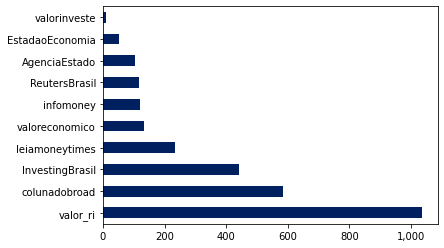

In [39]:
newDF = pd.DataFrame({
 'source':percent,
}, index=sources)

sources_sorted = newDF.sort_values('source',ascending=False)
ax = sources_sorted.source.plot(kind='barh',color='#002060')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [40]:
#Sentiment Analysis in Português and English
nltk.download('punkt')

base_path = './ReLi-Lex'
train = []
wordsPT = []
wordsPT_sentiments = []

files = [os.path.join(base_path, f) for f in os.listdir(base_path)]

for file in files:
    t = 1 if '_Positivos' in file else -1
    with open(file, 'r', encoding="ISO-8859-1") as content_file:
        content = content_file.read()
        all = re.findall('\[.*?\]',content)
        for w in all:
            wordsPT.append((w[1:-1]))
            wordsPT_sentiments.append(t)
            train.append((w[1:-1], t))

cl = NaiveBayesClassifier(train)

[nltk_data] Downloading package punkt to /home/vineasouza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [42]:
def sentiment(tweet):
    
    polarity = 0
    
    #blob = TextBlob(tweet, classifier=cl)
    blob = TextBlob(clean_tweet(tweet), classifier=cl) #Clean Tweets
    
    for s in blob.sentences:
        polarity = s.classify() + polarity
    
    if polarity > 0:
        return 1
    elif polarity < 0:
        return -1
    else:
        return 0

In [43]:
def analize_sentimentEN(tweet):
    
    analysis = TextBlob(tweet)
    
    if analysis.detect_language() != 'en':
        analysis = TextBlob(str(analysis.translate(to='en')))
        time.sleep(0.5)    
        
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [44]:
df['SA TextBlob'] = np.array([ sentiment(tweet) for tweet in df['tweet'] ]) #Portuguese Dictionary

In [45]:
#Sentiment Analysis Results
pos_tweets = [ tweet for index, tweet in enumerate(df['tweet']) if df['SA TextBlob'][index] > 0]
neg_tweets = [ tweet for index, tweet in enumerate(df['tweet']) if df['SA TextBlob'][index] < 0]

In [46]:
print("Porcentagem de Tweets Positivos: {}%".format(len(pos_tweets)*100/len(df['tweet'])))
print("Porcentagem de Tweets Negativos: {}%".format(len(neg_tweets)*100/len(df['tweet'])))

Porcentagem de Tweets Positivos: 96.32508833922262%
Porcentagem de Tweets Negativos: 3.674911660777385%


In [47]:
sentiments = ['Positivos', 'Negativos']
percents = [len(pos_tweets), len(neg_tweets)]

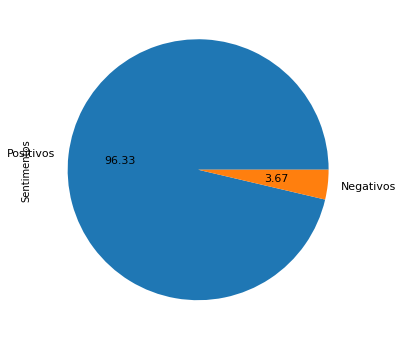

In [48]:
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

In [49]:
stopwords= set(STOPWORDS)

new_words = []
with open("stopwords.txt", 'r') as f:
    [new_words.append(word) for line in f for word in line.split()]

new_stopwords = stopwords.union(new_words)

In [28]:
# Define functions to process Tweet text and remove stop words
def ProTweets(tweet):
    tweet = ''.join(c for c in tweet if c not in string.punctuation)
    tweet = re.sub('((www\S+)|(http\S+))', 'urlsite', tweet)
    tweet = re.sub(r'\d+', 'contnum', tweet)
    tweet = re.sub(' +',' ', tweet)
    tweet = tweet.lower().strip()
    return tweet

def rmStopWords(tweet, stop_words):
    text = tweet.split()
    text = ' '.join(word for word in text if word not in stop_words)
    return text

In [29]:
# Get list of stop words
stop_words = get_stop_words('portuguese')
stop_words = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]
stop_words = [t.encode('utf-8') for t in stop_words]

# Preprocess all tweet data
pro_tweets = []
for tweet in df['tweet']:
    processed = ProTweets(tweet)
    pro_stopw = rmStopWords(processed, stop_words)
    pro_tweets.append(pro_stopw)

df['tweet'] = pro_tweets

In [50]:
words = ' '.join(df['tweet'])

words_clean = " ".join([word for word in words.split()
                            if 'https' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

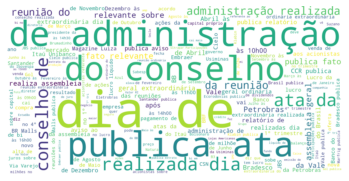

In [51]:
from imageio import imread
import warnings

warnings.simplefilter('ignore')

#twitter_mask = imread('brasil_mask.png')

wc = WordCloud(min_font_size=10, 
               max_font_size=300, 
               background_color='white', 
               mode="RGB",
               stopwords=new_stopwords,
               width=2000, 
               height=1000,
               #mask=twitter_mask,
               normalize_plurals= True).generate(words_clean)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
#plt.savefig('lula-bolsonaro.png', dpi=300)
plt.show()


In [76]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(wordsPT)
modelo = MultinomialNB()
modelo.fit(freq_tweets,wordsPT_sentiments);

In [77]:
tweetsarray = []

for tw in df['tweet']:
    text = clean_tweet(tw)
    tweetsarray.append(text)

In [99]:
predictionData = vectorizer.transform(df['tweet'])
# Perform classification on an array of test vectors X.
df['SA NLTK'] = modelo.predict(predictionData)

# Return probability estimates for the test vector X.
df['SA NLTK'] = modelo.predict_proba(predictionData)

In [100]:
print(df['SA NLTK'])

tweet_id
1128984581330407424    0.190408
1128600913092857856    0.034259
1128245224294293504    0.367816
1127542253159952384    0.116324
1127153121363419137    0.719646
                         ...   
846478513842651136     0.260784
846011317156827137     0.178373
845265994608193536     0.175494
844949553161932803     0.208406
844237866146447360     0.514174
Name: SA NLTK, Length: 2830, dtype: float64


In [80]:
#Sentiment Analysis Results
pos_tweets = [ tweet for index, tweet in enumerate(df['tweet']) if df['SA NLTK'][index] > 0]
neg_tweets = [ tweet for index, tweet in enumerate(df['tweet']) if df['SA NLTK'][index] < 0]

In [81]:
print("Porcentagem de Tweets Positivos: {}%".format(len(pos_tweets)*100/len(df['tweet'])))
print("Porcentagem de Tweets Negativos: {}%".format(len(neg_tweets)*100/len(df['tweet'])))

Porcentagem de Tweets Positivos: 93.71024734982332%
Porcentagem de Tweets Negativos: 6.289752650176679%


In [57]:
sentiments = ['Positivos', 'Negativos']
percents = [len(pos_tweets), len(neg_tweets)]

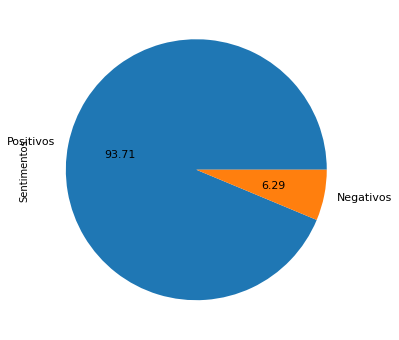

In [58]:
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

In [82]:
# Title

positive = 0;
negative = 0;

with open('datasetReviewed.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    next(plots)
    for row in plots:
        if int(row[8]) == 0 or int(row[8]) == 1:
            positive+=1
        else:


In [83]:
total = positive + negative

percentual_positivo = (positive/total)*100
percentual_negativo = (negative/total)*100

In [84]:
sentiments = ['Positivos', 'Negativos']
percents = [percentual_positivo, percentual_negativo]

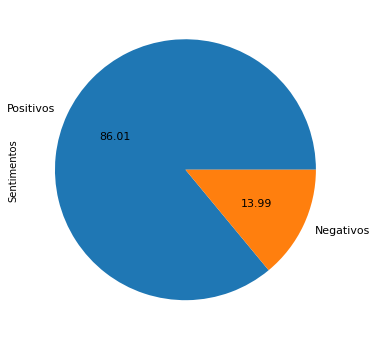

In [85]:
pie_chart = pd.Series(percents, index=sentiments, name='Sentimentos')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));